
# Imports




In [434]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import csv
import json

In [435]:
!pip install xlsxwriter
!pip install geopandas
!pip install contextily

**Exploratory Data Analysis**

In [436]:
df = pd.read_csv('./dataset/Psittaciformes.csv',
                 on_bad_lines='skip',
                 encoding='utf-8',
                 dtype=str,  # Read all as string first
                 skip_blank_lines=True,
                 header=0,
                 skipinitialspace=True)

In [437]:
print(df.columns)

Index(['scientificName', 'kingdomName', 'phylumName', 'className', 'orderName',
       'familyName', 'genusName', 'speciesName', 'redlistCategory',
       'redlistCriteria', 'yearPublished', 'assessmentDate', 'criteriaVersion',
       'language', 'populationTrend', 'systems', 'realm', 'yearLastSeen',
       'possiblyExtinct', 'possiblyExtinctInTheWild', 'scopes', 'Sequence',
       'Avibase.ID1', 'Total.individuals', 'Female', 'Male', 'Unknown',
       'Complete.measures', 'Beak.Length_Culmen', 'Beak.Length_Nares',
       'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 'Wing.Length',
       'Kipps.Distance', 'Secondary1', 'Hand-Wing.Index', 'Tail.Length',
       'Mass', 'Mass.Source', 'Mass.Refs.Other', 'Inference',
       'Traits.inferred', 'Reference.species', 'Habitat', 'Habitat.Density',
       'Migration', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle',
       'Min.Latitude', 'Max.Latitude', 'Centroid.Latitude',
       'Centroid.Longitude', 'Range.Size', 'internalTaxonId_x', '

In [438]:
basic_columns_list = [
    'scientificName',
    'familyName',
    'orderName',

    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass',

    'Habitat',
    'Habitat.Density',
    'Min.Latitude',
    'Max.Latitude',
    'Centroid.Latitude',
    'Centroid.Longitude',
    'Range.Size',


    'redlistCategory',
    'populationTrend',
    'threats',
    'Trophic.Level',
    'Trophic.Niche',
    'Primary.Lifestyle',

]

In [439]:
df = df[basic_columns_list]


In [440]:
def analyze_habitats(data):
    """
    List and count unique habitat values
    """
    # Get unique habitats and their counts
    habitat_counts = data['Habitat'].value_counts()

    print("Unique Habitats and their counts:\n")
    print("Habitat Type".ljust(50), "Count")
    print("-" * 60)

    for habitat, count in habitat_counts.items():
        print(f"{str(habitat).ljust(50)} {count}")

    print("\nTotal number of unique habitats:", len(habitat_counts))
    print("Total number of records:", len(data))
    print("Number of null/missing values:", data['Habitat'].isna().sum())


In [441]:
analyze_habitats(df)

Unique Habitats and their counts:

Habitat Type                                       Count
------------------------------------------------------------
Forest                                             318
Woodland                                           49
Shrubland                                          22
Grassland                                          7
Human Modified                                     2
Desert                                             1

Total number of unique habitats: 6
Total number of records: 401
Number of null/missing values: 2


In [442]:
def plot_samples_per_latitude(data, n_lat_bins=10):
    """
    Create a histogram showing number of Birds per latitude band
    """
    # Convert latitude to numeric
    lat = pd.to_numeric(data['Centroid.Latitude'], errors='coerce')

    # Remove NaN values
    lat = lat[~np.isnan(lat)]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create histogram
    counts, bins, _ = ax.hist(lat, bins=n_lat_bins, color='skyblue',
                             edgecolor='black', alpha=0.7)

    # Add count labels on top of each bar
    for i in range(len(counts)):
        ax.text(bins[i] + (bins[i+1]-bins[i])/2, counts[i],
                f'{int(counts[i])}',
                horizontalalignment='center',
                verticalalignment='bottom')

    # Customize plot
    ax.set_title('Number of Birds per Latitude Band', pad=20)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Number of Birds')

    # Add grid
    ax.grid(True, alpha=0.2)

    # Add total sample size
    ax.text(0.98, 0.98, f'Total Birds = {len(lat)}',
            transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    return fig

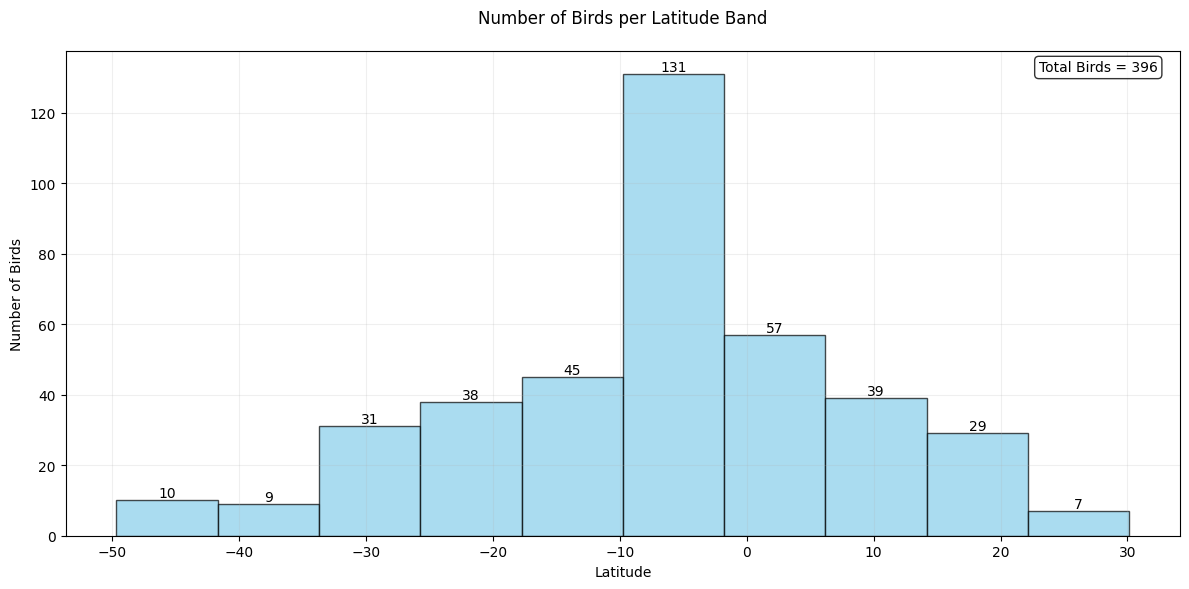

In [443]:
# Create the plot
fig = plot_samples_per_latitude(df)
plt.show()

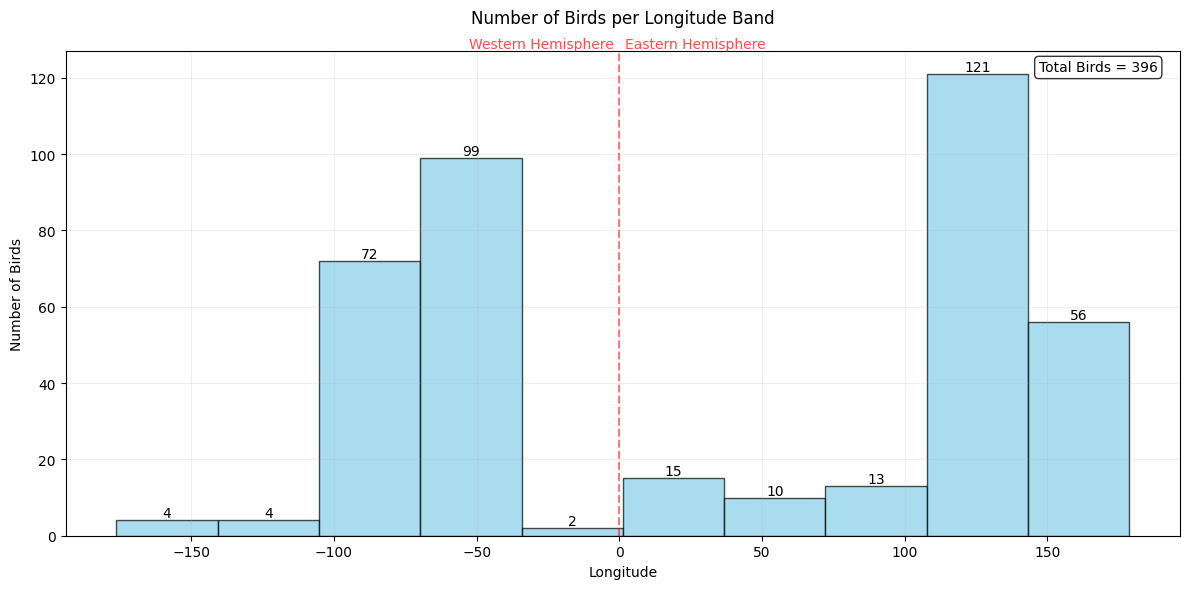

In [444]:
def plot_samples_per_longitude(data, n_lon_bins=10):
    """
    Create a histogram showing number of Birds per longitude band
    """
    # Convert longitude to numeric
    lon = pd.to_numeric(data['Centroid.Longitude'], errors='coerce')

    # Remove NaN values
    lon = lon[~np.isnan(lon)]

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create histogram
    counts, bins, _ = ax.hist(lon, bins=n_lon_bins, color='skyblue',
                             edgecolor='black', alpha=0.7)

    # Add count labels on top of each bar
    for i in range(len(counts)):
        ax.text(bins[i] + (bins[i+1]-bins[i])/2, counts[i],
                f'{int(counts[i])}',
                horizontalalignment='center',
                verticalalignment='bottom')

    # Customize plot
    ax.set_title('Number of Birds per Longitude Band', pad=20)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Number of Birds')

    # Add grid
    ax.grid(True, alpha=0.2)

    # Add total sample size
    ax.text(0.98, 0.98, f'Total Birds = {len(lon)}',
            transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add hemisphere lines and labels
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax.text(2, ax.get_ylim()[1], 'Eastern Hemisphere',
            color='red', alpha=0.7, ha='left', va='bottom')
    ax.text(-2, ax.get_ylim()[1], 'Western Hemisphere',
            color='red', alpha=0.7, ha='right', va='bottom')

    plt.tight_layout()
    return fig


fig = plot_samples_per_longitude(df)
plt.show()

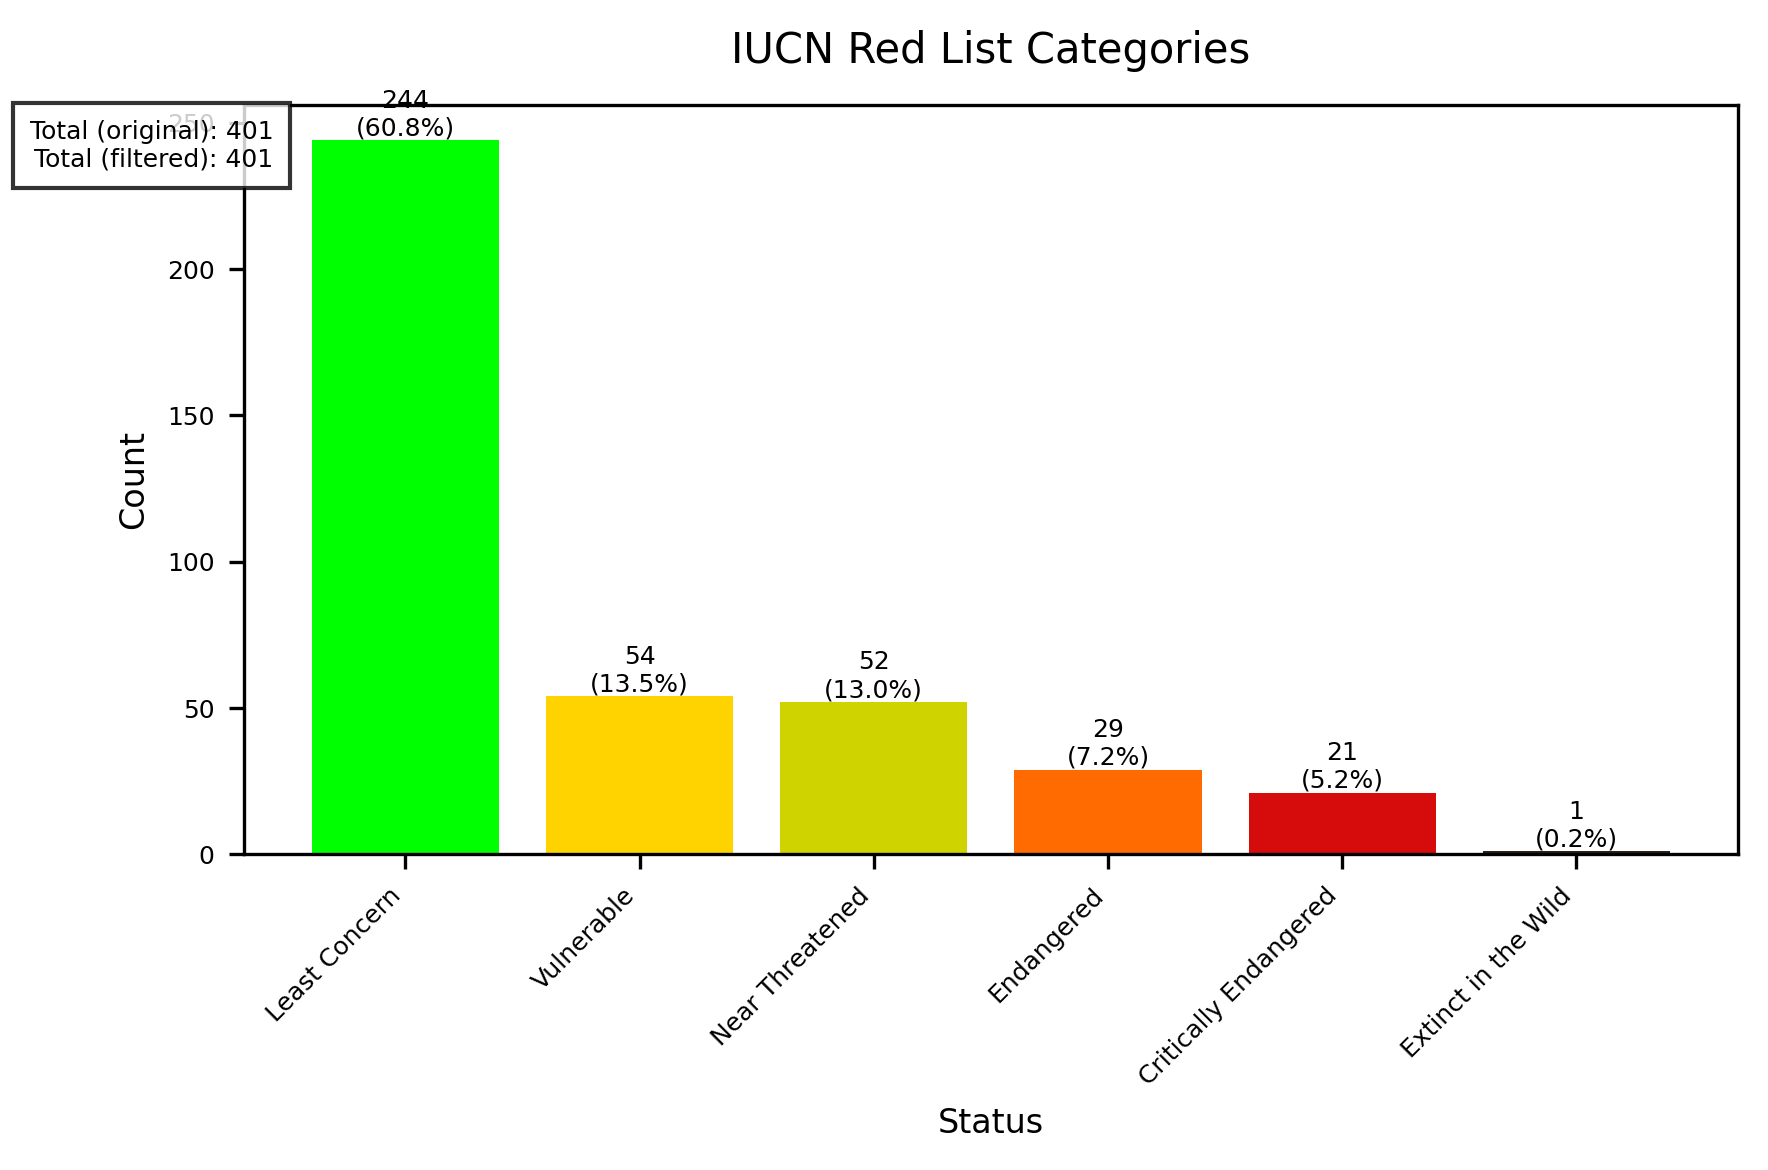

In [445]:
def plot_redlist_distribution(df, figsize=(6, 4), dpi=300):
    """
    Creates a histogram/distribution plot of Red List categories with smaller dimensions
    """
    # Define valid categories and filter
    valid_categories = [
        'Least Concern',
        'Vulnerable',
        'Endangered',
        'Critically Endangered',
        'Extinct in the Wild',
        'Near Threatened',
        'Extinct'
    ]

    df_filtered = df[df['redlistCategory'].isin(valid_categories)]




    # Define IUCN Red List colors
    colors = {
        'Least Concern': '#00FF00',        # Green
        'Vulnerable': '#FFD300',# Yellow
        'Near Threatened': '#CFD300',
        'Endangered': '#FF6B00',           # Orange
        'Critically Endangered': '#D60B0B', # Red
        'Extinct in the Wild': '#2D1F15',  # Dark Brown
        'Extinct': '#000000',              # Black
    }

    # Calculate value counts and percentages
    counts = df_filtered['redlistCategory'].value_counts()
    total_filtered = len(df_filtered)
    total_original = len(df)

    # Create figure with smaller size
    plt.figure(figsize=figsize, dpi=dpi)

    # Create bar plot
    bars = plt.bar(range(len(counts)), counts,
                  color=[colors.get(x, '#808080') for x in counts.index])

    # Customize plot with smaller font sizes
    plt.title('IUCN Red List Categories', pad=10, fontsize=10)
    plt.xlabel('Status', fontsize=8)
    plt.ylabel('Count', fontsize=8)

    # Rotate x-axis labels with smaller font
    plt.xticks(range(len(counts)), counts.index, rotation=45, ha='right', fontsize=6)
    plt.yticks(fontsize=6)

    # Add count labels with smaller font
    for bar in bars:
        height = bar.get_height()
        percentage = (height/total_filtered) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=6)

    # Add both totals to upper right
    plt.text(0.02, 0.98,
             f'Total (original): {total_original:,}\nTotal (filtered): {total_filtered:,}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             horizontalalignment='right',
             fontsize=6)

    plt.tight_layout()

    return plt.gcf()


fig = plot_redlist_distribution(df)
plt.show()


# Creating the morphological network

In [446]:
traits = [
    'Beak.Length_Culmen',
    'Beak.Length_Nares',
    'Beak.Width',
    'Beak.Depth',
    'Tarsus.Length',
    'Wing.Length',
    'Kipps.Distance',
    'Hand-Wing.Index',
    'Tail.Length',
    'Mass'
]


In [447]:
unique_values = df['familyName'].unique()
print(unique_values)

['PSITTACIDAE' 'CACATUIDAE' 'STRIGOPIDAE']


In [448]:
def standardize_traits(df_traits, traits):
    """Standardize/Normalize morphological traits."""
    scaler = StandardScaler()
    standardized_traits = scaler.fit_transform(df_traits[traits])
    species_names = df_traits['scientificName'].values
    return standardized_traits, species_names

def compute_similarity(standardized_traits):
    """
    Compute cosine similarity between species and ensure values are in [-1,1] range.

    Parameters:
        standardized_traits: numpy array of standardized morphological traits
    Returns:
        similarity_matrix: numpy array of pairwise similarities
    """
    # Compute cosine similarity
    similarity_matrix = cosine_similarity(standardized_traits)


    # Additional checks
    print("Similarity matrix range:",
          f"min: {similarity_matrix.min():.3f}, max: {similarity_matrix.max():.3f}")


    return similarity_matrix

In [449]:
import networkx as nx
import numpy as np
import json

def create_knn_network(similarity_matrix, species_names, df_data, k=5, similarity_threshold=0.7):
    """
    Create network with node attributes and k-nearest neighbor connections,
    applying a similarity threshold. Returns only the largest connected component.

    Parameters:
        similarity_matrix: Matrix of pairwise species similarities
        species_names: List of species names
        df_data: DataFrame containing species attributes
        k: Number of nearest neighbors to consider for each node
        similarity_threshold: Minimum similarity score for creating an edge

    Returns:
        G_knn: NetworkX graph object representing the largest component of the KNN network
    """
    G_knn = nx.Graph()

    # Define categories and their keywords
    categories = {
        'Trade': ["trade"],
        'Habitat Loss': ["habitat", "loss", "forest", "areas"],
        'Climate Change': ["cyclones", "natural", "climate"],
        'Diseases': ["avian", "malaria"],
        'Predation': ["predators"],
        'Human Activity': ["hunting", "logging", "agriculture"],
        'Pollution': ["pollution"],
    }

    def categorize_threat(threat, category_keywords):
        if not isinstance(threat, str):  # Check if the threat is not a string
            return []  # Return an empty list if no threats
        return [cat for cat, keywords in category_keywords.items() if any(keyword in threat.lower() for keyword in keywords)]

    # Add nodes with attributes
    for species in species_names:
        species_data = df_data[df_data['scientificName'] == species].iloc[0]

        threats = species_data.get('threats', '')
        threat_categories = categorize_threat(threats, categories)
        threat_categories = [t for t in threat_categories if t]
        threat_categories_json = json.dumps(threat_categories)

        G_knn.add_node(
            species,
            latitude=species_data['Centroid.Latitude'],
            longitude=species_data['Centroid.Longitude'],
            family=species_data['familyName'],
            habitat=species_data['Habitat'],
            trophic_level=species_data['Trophic.Level'],
            trophic_niche=species_data['Trophic.Niche'],
            primary_lifestyle=species_data['Primary.Lifestyle'],
            redlist_category=species_data['redlistCategory'],
            scientific_name=species,
            threats=threat_categories_json
        )

    # Set diagonal to negative infinity to exclude self-connections
    np.fill_diagonal(similarity_matrix, -np.inf)

    # Add edges based on k-nearest neighbors and similarity threshold
    for i in range(len(species_names)):
        similarities = similarity_matrix[i]
        # Get the k most similar species, but only if above threshold
        most_similar_indices = np.where(similarities >= similarity_threshold)[0]
        # Sort by similarity, take the top k, excluding self
        most_similar_indices = most_similar_indices[np.argsort(similarities[most_similar_indices])[::-1][:k]]

        # Add edges to nearest neighbors that meet the threshold
        for j in most_similar_indices:
            if j != i:  # Ensure no self-loops
                G_knn.add_edge(
                    species_names[i],
                    species_names[j],
                    weight=similarity_matrix[i][j]
                )

    # Check for self-loops
    self_loops = list(nx.selfloop_edges(G_knn))
    if self_loops:
        print("Warning: Self-loops found in the network:")
        for edge in self_loops:
            print(f"Self-loop found for node: {edge[0]}")
    else:
        print("No self-loops found in the network")

    # Extract the largest connected component
    largest_component = max(nx.connected_components(G_knn), key=len)
    G_largest_component = G_knn.subgraph(largest_component).copy()

    # Network statistics for the largest component
    print(f"\nLargest Component Statistics:")
    print(f"Number of nodes in largest component: {G_largest_component.number_of_nodes()}")
    print(f"Number of edges in largest component: {G_largest_component.number_of_edges()}")
    print(f"Average degree in largest component: {sum(dict(G_largest_component.degree()).values()) / G_largest_component.number_of_nodes():.2f}")

    return G_largest_component

In [450]:
# 1. Data Preparation
df_traits = df[['scientificName'] + traits].copy()
df_traits = df_traits.dropna()

# 2. Data Standardization
standardized_traits, species_names = standardize_traits(df_traits, traits)

# 3. Similarity Calculation
# Compute cosine similarity between all pairs of species
# Result is a square matrix where each cell[i,j] is similarity between species i and j
similarity_matrix = compute_similarity(standardized_traits)

Similarity matrix range: min: -0.989, max: 1.000


In [451]:
# Visualize similarity distribution
def plot_similarity_distribution(similarity_matrix):
    """
    Plot the distribution of similarity values
    """
    plt.figure(figsize=(10, 6))
    # Get upper triangle values
    upper_tri = similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)]

    plt.hist(upper_tri, bins=50)
    plt.title('Distribution of Similarity Values')
    plt.xlabel('Similarity')
    plt.ylabel('count')


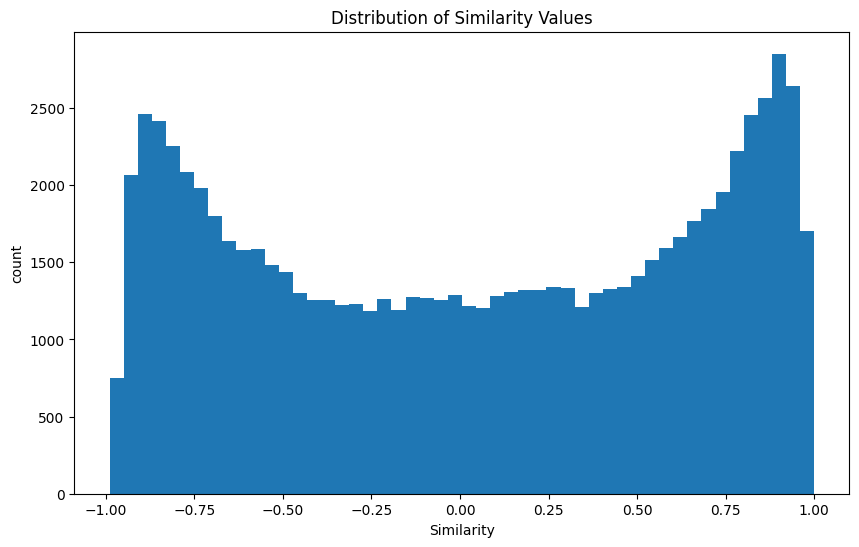

In [452]:
plot_similarity_distribution(similarity_matrix)

In [453]:
# Save similarity matrix
similarity_df = pd.DataFrame(similarity_matrix,
                           index=species_names,
                           columns=species_names)
similarity_df.to_excel('similarity_matrix.xlsx')

In [454]:
G_knn = create_knn_network(
        similarity_matrix=similarity_matrix,
        species_names=species_names,
        df_data=df,
        k=5
)

No self-loops found in the network

Largest Component Statistics:
Number of nodes in largest component: 398
Number of edges in largest component: 1372
Average degree in largest component: 6.89


In [455]:
def save_graph_to_graphml(G, filename, compress=True):
    """
    Save network to GraphML format with proper attribute handling

    Parameters:
    G: NetworkX graph
    filename: Output filename (with or without extension)
    compress: Boolean, whether to compress the output file
    """
    try:
        # Ensure proper file extension
        if not filename.endswith('.graphml'):
            filename += '.graphml'

        if compress and not filename.endswith('.gz'):
            filename += '.gz'

        # Convert all attributes to strings to ensure compatibility
        G_save = G.copy()

        # Handle node attributes
        for node, attrs in G_save.nodes(data=True):
            for key, value in attrs.items():
                if isinstance(value, (list, dict, set)):
                    G_save.nodes[node][key] = str(value)
                elif pd.isna(value):
                    G_save.nodes[node][key] = ''

        # Handle edge attributes
        for u, v, attrs in G_save.edges(data=True):
            for key, value in attrs.items():
                if isinstance(value, (list, dict, set)):
                    G_save[u][v][key] = str(value)
                elif pd.isna(value):
                    G_save[u][v][key] = ''

        # Save the graph
        nx.write_graphml(G_save, filename)

        print(f"Graph successfully saved to {filename}")

        # Print some statistics
        print(f"\nSaved graph statistics:")
        print(f"Nodes: {G_save.number_of_nodes()}")
        print(f"Edges: {G_save.number_of_edges()}")
        print(f"Node attributes: {list(next(iter(G_save.nodes(data=True)))[1].keys())}")
        edge_attrs = list(next(iter(G_save.edges(data=True)))[2].keys()) if G_save.number_of_edges() > 0 else []
        print(f"Edge attributes: {edge_attrs}")

        return True

    except Exception as e:
        print(f"Error saving graph: {str(e)}")
        return False

In [456]:
save_graph_to_graphml(G_knn, 'morphological_parrot_network.graphml', compress=False)

Graph successfully saved to morphological_parrot_network.graphml

Saved graph statistics:
Nodes: 398
Edges: 1372
Node attributes: ['latitude', 'longitude', 'family', 'habitat', 'trophic_level', 'trophic_niche', 'primary_lifestyle', 'redlist_category', 'scientific_name', 'threats']
Edge attributes: ['weight']


True

In [457]:
def analyze_connectivity(G):
    # Check if graph is connected
    is_connected = nx.is_connected(G)

    # Get connected components
    components = list(nx.connected_components(G))
    n_components = len(components)

    # Get largest component
    largest_component = max(components, key=len)

    # Calculate size metrics
    total_nodes = G.number_of_nodes()
    largest_component_size = len(largest_component)
    largest_component_ratio = largest_component_size / total_nodes

    # Create subgraph of largest component
    G_largest = G.subgraph(largest_component)

    # Print analysis
    print(f"Graph Connectivity Analysis:")
    print(f"Is connected: {is_connected}")
    print(f"Number of components: {n_components}")
    print(f"Total nodes: {total_nodes}")
    print(f"Total edges: {G.number_of_edges()}")
    print(f"Largest component size: {largest_component_size}")
    print(f"Largest component ratio: {largest_component_ratio:.2%}")

    # Visualize components
    plt.figure(figsize=(15, 10))

    # Position all nodes using spring layout
    pos = nx.spring_layout(G)

    # Draw each component in a different color
    colors = plt.cm.rainbow(np.linspace(0, 1, n_components))
    for idx, component in enumerate(components):
        nx.draw_networkx_nodes(G, pos,
                             nodelist=list(component),
                             node_color=[colors[idx]],
                             node_size=100,
                             alpha=0.7)

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)

    # Add labels for larger components
    component_sizes = [len(c) for c in components]
    for idx, (component, size) in enumerate(zip(components, component_sizes)):
        if size > total_nodes * 0.05:  # Label components with >5% of nodes
            center_x = np.mean([pos[node][0] for node in component])
            center_y = np.mean([pos[node][1] for node in component])
            plt.text(center_x, center_y, f'Component {idx+1}\n({size} nodes)',
                    horizontalalignment='center',
                    verticalalignment='center',
                    bbox=dict(facecolor='white', alpha=0.7))

    plt.title("Connected Components Visualization")
    plt.axis('off')
    plt.show()

    return {
        'is_connected': is_connected,
        'n_components': n_components,

        'largest_component_size': largest_component_size,
        'largest_component_ratio': largest_component_ratio,

    }

Graph Connectivity Analysis:
Is connected: True
Number of components: 1
Total nodes: 398
Total edges: 1372
Largest component size: 398
Largest component ratio: 100.00%


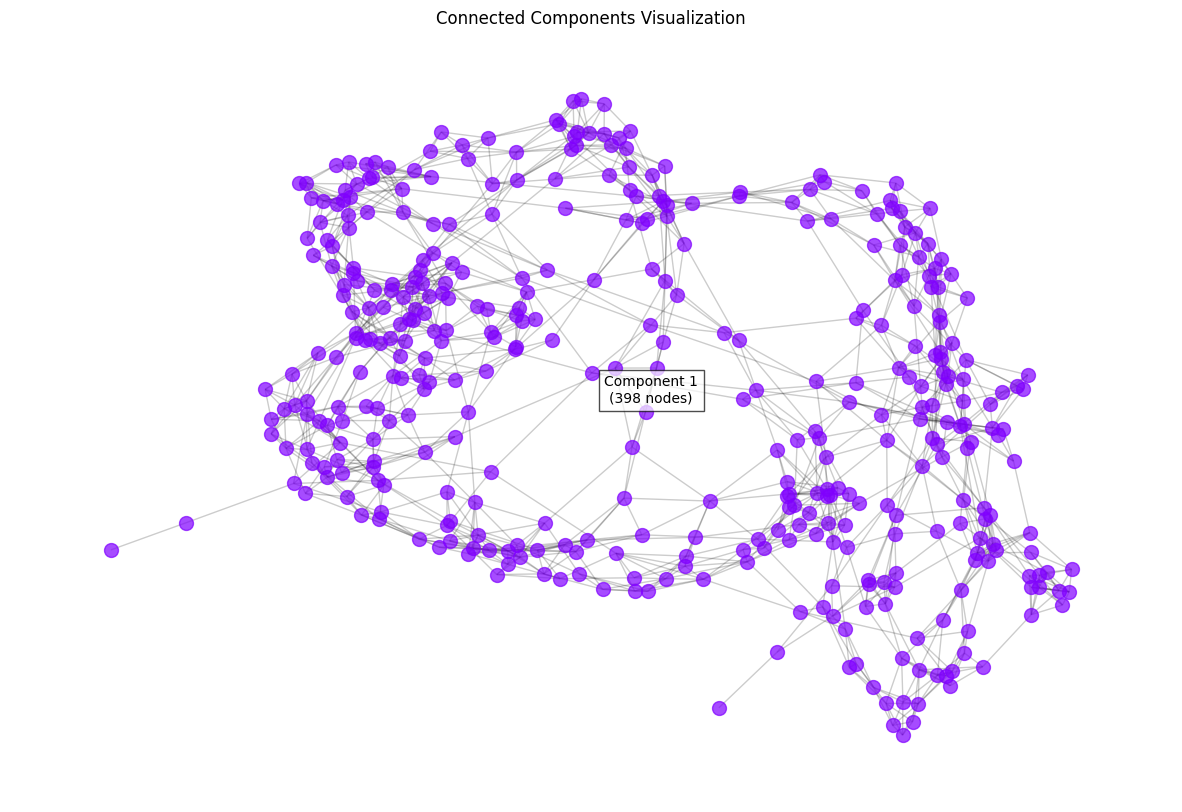

{'is_connected': True,
 'n_components': 1,
 'largest_component_size': 398,
 'largest_component_ratio': 1.0}

In [458]:
analyze_connectivity(G_knn)

In [459]:

from community import community_louvain

def graphml_to_json_custom(graphml_path, json_path, threat_categories):
    """
    Convert GraphML to custom JSON format with separate node and edge lists,
    add all matching threats for each bird (node), and include community detection as node attributes.
    """
    def categorize_threat(threat, category_keywords):
        """
        Return a list of all matching threat categories for the given threat description.
        """
        return [category for category, keywords in category_keywords.items()
                if any(keyword in threat.lower() for keyword in keywords)]

    # Read the GraphML file
    G = nx.read_graphml(graphml_path)

    # Detect communities using Louvain method
    partition = community_louvain.best_partition(G)

    # Add community information as node attributes
    for node, community_id in partition.items():
        G.nodes[node]['community'] = community_id

    # Create custom format
    graph_data = {
        'nodes': [],
        'edges': []
    }

    # Add nodes with attributes including community
    for node, attrs in G.nodes(data=True):
        node_data = attrs.copy()  # Copy all attributes including community
        node_data['id'] = node
        # Add all threats if threat information exists
        if 'threats' in attrs:
            node_data['threat_categories'] = []
            for threat in attrs['threats']:
                node_data['threat_categories'].extend(categorize_threat(threat, threat_categories))
        graph_data['nodes'].append(node_data)

    # Add edges with attributes
    for source, target, attrs in G.edges(data=True):
        edge_data = {
            'source': source,
            'target': target
        }
        edge_data.update(attrs)
        graph_data['edges'].append(edge_data)

    # Save to file
    with open(json_path, 'w') as f:
        json.dump(graph_data, f, indent=2)

    print(f"Nodes: {len(graph_data['nodes'])}")
    print(f"Edges: {len(graph_data['edges'])}")
    print(f"Communities detected: {len(set(partition.values()))}")
    return graph_data


categories = {
    'Trade': ['trade'],
    'Habitat Loss': ['habitat', 'loss', 'forest', 'areas'],
    'Climate Change': ['cyclones', 'natural', 'climate'],
    'Diseases': ['avian', 'malaria'],
    'Predation': ['predators'],
    'Human Activity': ['hunting', 'logging', 'agriculture'],
    'Pollution': ['pollution'],
}


graphml_path = 'morphological_parrot_network.graphml'
json_path = 'morphological_parrot_network.json'

# Generate JSON with threats for each bird and community information as node attributes
graphml_to_json_custom(graphml_path, json_path, categories)


Nodes: 398
Edges: 1372
Communities detected: 14


{'nodes': [{'latitude': '4.21',
   'longitude': '126.78',
   'family': 'PSITTACIDAE',
   'habitat': 'Forest',
   'trophic_level': 'Herbivore',
   'trophic_niche': 'Frugivore',
   'primary_lifestyle': 'Insessorial',
   'redlist_category': 'Endangered',
   'scientific_name': 'Eos histrio',
   'threats': '["Trade", "Habitat Loss", "Human Activity"]',
   'community': 0,
   'id': 'Eos histrio',
   'threat_categories': []},
  {'latitude': '-8.98',
   'longitude': '125.22',
   'family': 'PSITTACIDAE',
   'habitat': 'Forest',
   'trophic_level': 'Herbivore',
   'trophic_niche': 'Nectarivore',
   'primary_lifestyle': 'Insessorial',
   'redlist_category': 'Least Concern',
   'scientific_name': 'Trichoglossus euteles',
   'threats': '[]',
   'community': 1,
   'id': 'Trichoglossus euteles',
   'threat_categories': []},
  {'latitude': '7.32',
   'longitude': '124.74',
   'family': 'PSITTACIDAE',
   'habitat': 'Forest',
   'trophic_level': 'Herbivore',
   'trophic_niche': 'Nectarivore',
   'primary